# Scikit-learn

Machine learning is a very broad field, and you will get a more detailed course on this in your second year. We will provide some minor background information, but as time is limited we will only focus on Linear regression and K-means Clustering.

Most techniques within Machine Learning can be divided within two groups (although there are many of these splits that you could make, e.g. supervised vs. unsupervised). Those being Regression algorithms and Classification algorithims. These two type of algorithms tackle two distinct problems.

Throughout the notebook you will find some links to videos of Andrew Ng (some of his videos can safely be viewed at 1.5x speed). Here they use $\theta$ to refer to the parameters you learn, so apart from notation, the material is the same.

## Regression
With regression you assume that the values come from some sort of function, and you try to find this function. Most techniques will try to fit some mathematical function that describes a curve, such that the curve passes as close as possible to all the data points. 

## Classification
Classification is discrete, an object belongs to precisely one class, and the set of all classes covers all posibilities. You have no values in-between classes. 

## Supervised Learning
Can be applied to data that has both features and labels. Your task usually exsits of contructing an estimator which is able to predict the label of an object given its features.

Useful video: 
* [Supervised Learning](https://www.youtube.com/watch?v=ls7Ke48jCt8&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=3)
* [Linear Regression](https://www.youtube.com/watch?v=PBZUjnGuXjA&index=5&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

## Unsupervised Learning
Can be applies to data that has no labels, and with these techniques we attempt to find interesting similarities between the objects. You are essentially trying to discover labels yourself.

Useful video: [Unsupervised Learning](https://www.youtube.com/watch?v=qHfUlFHGG08&index=4&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

# Linear Regression

We will be going over how to use the scikit-learn regression model, as well as how to train the regressor using the `fit()` method, and how to predict new labels using the `predict()` method. From time to time we might introduce some mathematics as well, but the intention is to focus on implementation details.

If you're interested in the deeper mathematics of linear regession methods, check out the [wikipedia page](http://en.wikipedia.org/wiki/Linear_regression).

## Setup and Data
For the following examples we will be using a built-in data set (quite convenient) containing housing prices of Boston. The following code will contain the imports for numpy, bokeh, pandas and the dataset from sklearn.

In [1]:
import numpy as np

import pandas as pd
from pandas import Series,DataFrame
from bokeh.layouts import gridplot, row, column

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

from sklearn.datasets import load_boston

# For very simple visualizations (without too much interaction, output_notebook works too, which we enable here)
output_notebook()

Loading BokehJS ...

In [2]:
# Load the housing dataset - a dictionary
boston = load_boston()
print(boston.keys())
# Let's see some details
print(boston.DESCR)

dict_keys(['data', 'target', 'feature_names', 'DESCR'])
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,0

So with the above information we deduce that we have some variables stored under de `data` key, the names of each of these features stored in `feature_names`, and that we have their expected prices stored in `target`. We might as well whip the `data` into a DataFrame as well, while we are at it.

In [3]:
# set data as pandas DataFrame
boston_df = DataFrame(boston.data)

# label columns
boston_df.columns = boston.feature_names

# Add target prices
boston_df['Price'] = boston.target

#show
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Let us now do an initial visualisation, to explore to some degree what we have

In [4]:
# Create the figure object
f = figure(plot_width=400, plot_height=250)

# Make a histogram
hist, edges = np.histogram(boston_df["Price"], density=True, bins=50)

f.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")

## Add some axis information (after all, a plot without axis descriptions is nothing more than abstract art)
f.xaxis.axis_label = "Price in $1000s"
f.yaxis.axis_label = "Number of houses"

show(f)

I suppose it appears number of houses are quite dense near the $20.000 mark. Let us look into it a little further (before we actually start looking at the linear regression). We will plot the features, to see if we can find any correlation that could potential be used to predict the price with. We will inspect the first 6 features. Namely:

* CRIM:     per capita crime rate by town
* ZN:       proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS:    proportion of non-retail business acres per town
* CHAS:     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX:      nitric oxides concentration (parts per 10 million)
* RM:       average number of rooms per dwelling

In [5]:
# You can see what these names mean in the description that we printed at the start
print(boston.feature_names[:6])

figures = [figure() for _ in range(6)]
for index, fig in enumerate(figures):
    # Create a scatter-plot
    fig.scatter(boston_df[boston.feature_names[index]], boston_df["Price"])
    
    ## Add some axis information
    fig.xaxis.axis_label = boston.feature_names[index]
    fig.yaxis.axis_label = "Price in $1000s"

    
show(gridplot(figures, ncols=2, plot_width=400, plot_height=250, toolbar_location=None))

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM']


So out of the plotted variables RM looks quite promising to perhaps be fitted by a linear function. So let's go with that one for now for our linear regression example.

For the sake of this initial example, I will first plot the fitted line using a simple univariate linear regression using Numpy, to explain the theorie. Afterwards we will run through multivariate regression using scikit-learn.

### Univariate Linear Regression (Using Numpy)

Numpy requires us to create two (N, 1) shaped arrays, that will act as the X and Y values. Where X represents the attribute (feature) and the Y represents the target. There are a few ways to do this, but an easy way to do this is by using numpy's built-in vertical stack tool, vstack.


In [49]:
# Set up X as median room values and use Use vstack to make X two-dimensional
# Remember that X normally is (N,) instead of (N,1).
X = np.vstack(boston_df.RM)

# Set up Y as the target price of the houses.
Y = boston_df.Price

# print(Y)

Now that we have our X and Y, let's go ahead and use numpy to create the single variable linear regression.

We know that a line has the equation:
$$y=ax+b$$
which we can rewrite using matrices:
$$y=Mp$$
where:
$$M = \begin{bmatrix}x & 1\end{bmatrix}$$
and
$$p= \begin{bmatrix}a \\b\end{bmatrix}$$

This is the same as the first equation if you carry out the linear algebra. 
So we'll start by creating the M matrix using numpy. We'll do this by creating a matrix in the form [X 1], so we'll call every value in our original X using a list comprehension and then set up an array in the form [X 1]

Side Note: In most literature the variables $y$, $a$, and $b$ are referred to differently, to make them more generalizable, namely $h(x)$ (derived from the word hypothesis), $\theta_1$, and $\theta_0$ respectively. We will keep them as $y$, $a$, and $b$ for the univariate example, as this notation is most hopefully more familiar/intuitive to you.

In [54]:
# Creating [X 1] (remember the useful np.ones function from the first notebook?)
X = np.vstack(boston_df.RM)
X = np.column_stack((X, np.ones(X.shape[0])))

# Now get out m and b values for our best fit line
a, b = np.linalg.lstsq(X, Y)[0]
print(a, b)

# print(X)
# print(Y)

9.102108981180313 -34.670620776438575


c:\users\boble\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


We now have all the ingredients to plot a line using:
$$y = ax + b$$

In [15]:
f = figure(plot_width=400, plot_height=250)

# Create a scatter-plot
f.scatter(boston_df["RM"], boston_df["Price"])
    
# Create the line
x = boston_df["RM"]
f.line(x, a * x + b, color='red')

## Add some axis information
f.xaxis.axis_label = boston.feature_names[index]
f.yaxis.axis_label = "Price in $1000s"

show(f)

### Computing the error
So we see that this line obviously does not cover all the points in our dataset. To determine how good our solution is, we compute an error measure. In order to see what error measure makes sense, we must also see what the least squares method actually tries to minimize:

If we recall that we want to make a line $\mathbf{y}=a\mathbf{x} +b$ that fits the data best. We want to minimize the distance of all points to this line (on the y scale). So if we assume that $\mathbf{r}$ is the real value of the data point, we could determine the error by taking the average of the sum of differences between the vectors $\mathbf{r}$ and $\mathbf{y}$ to determine how far our estimation deviates from the truth, naively this would look like:

$$J(a, b) = \frac{1}{N}\sum\limits_{i = 1}^{N} (r(i) - y(i) ),$$

where $y(i) = ax(i) + b$. As the above could also result into negative errors and we also kinda want to punish larger distances more, we square this error.

$$J(a, b) = \frac{1}{N}\sum\limits_{i = 1}^{N} (r(i) - y(i) )^2$$

The above is also referred to as the Mean Squared Error (MSE), and this is one of the most used error functions for regression problems. Sometimes you also see it defined slightly differently, with a $\frac{1}{2}$ added infront of the algorithm:

$$J(a, b) = \frac{1}{2N}\sum\limits_{i = 1}^{N} (r(i) - y(i) )^2$$

this is just to make certain mathematical tricks easier for other problems. This does not change it's function though, as minimizing the half of a certain cost function, essentially does the same as minimizing just the cost function.

We also have another cost function, called Root Mean Squared Error (RMSE), which is really just the following:

$$ \sqrt{MSE}$$

This function might be nice to use, because it is very similar to computing the standard deviation.

The goal of the algorithm in our univariate example is to minimize the cost function over $a$ and $b$. Which means that we want to find the best solution, while only modifying $a$ and $b$.

*These videos are great for building intuition on the relation between the hypothesis function and the associated cost of that hypothesis for the data.*
* [Cost function 1](https://www.youtube.com/watch?v=EANr4YttXIQ&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=6)
* [Cost function 2](https://www.youtube.com/watch?v=J5vJFwQWOaY&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=7)

So if we now want to compute this error for our example, we need a vector with the real prices, and the vector with our estimation.


In [16]:
r = np.array(boston_df["Price"])
x = np.array(boston_df["RM"])
y = a * x + b

print(len(x))
mse = sum((r-y) **2) / len(x)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

506
43.60055177116957
6.603071389222562


Since the root mean square error (RMSE) corresponds approximately to the standard deviation we can now say that the price of a house won't vary more than 2 times the RMSE 95% of the time. [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) and some additional [Theory](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)

Thus we can reasonably expect a house price to be within $13,200 of our line fit.

In [17]:
# Or just cheat and use built-ins to compute the MSE (but now you atleast know how it's done):
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(r, y)
print(mse)

43.60055177116956


## Multivariate Regression
As promised, we will not just stick to univariate regression. For multivariate regression we will maintain a similar strategy, but now we will use scikit-learn to use more than one feature.

We'll start by importing the [linear regression library](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from the sklearn module.

The sklearn.linear_model.LinearRegression class is an estimator. Estimators predict a value based on the observed data. In scikit-learn, all estimators implement the `fit()` and `predict()` methods. The former method is used to learn the parameters of a model, and the latter method is used to predict the value of a response variable for an explanatory variable using the learned parameters. It is easy to experiment with different models using scikit-learn because all estimators implement the fit and predict methods (more re-usable code!!).

In [18]:
# Import for Linear Regression
import sklearn
from sklearn.linear_model import LinearRegression

In [19]:
# Create a LinearRegression Object
lreg = LinearRegression()

The functions we will be using are:

* `lreg.fit()` which fits a linear model
* `reg.predict()` which is used to predict Y using the linear model with estimated coefficients
* `lreg.score()` which returns the coefficient of determination (R^2). A measure of how well observed outcomes are replicated by the model, learn more about it [here](http://en.wikipedia.org/wiki/Coefficient_of_determination)



But first we will split our DataFrame into data and target (pretty much going back to how we were handed the data originally, but now in a DataFrame). We then feed this data into the fit function.

In [55]:
# Data Columns
X_multi = boston_df.drop('Price',1)

# Targets
Y_target = boston_df.Price

# Implement Linear Regression
lreg.fit(X_multi,Y_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We can now also see how many of the variables were actually used for this prediction

In [21]:
# What is our constant? (b in univariate regression)
print(' The estimated intercept coefficient is {0:.2f}'.format(lreg.intercept_))

print(' The number of coefficients used was {0:d}'.format(len(lreg.coef_)))

 The estimated intercept coefficient is 36.49
 The number of coefficients used was 13


Here we see that 13 coefficients were used this time (the same amount as the columns in our feature set). Where with univariate we used only 1 ($a$). So this time we get:

$$ y(w,x) = w_0 + w_1 x_1 + ... + w_p x_p $$

Where 

$$w = (w_1, ...w_p)$$ 

as the coefficients and $ w_0 $ as the intercept 

We can also easily see these variables:

In [22]:
# Set a DataFrame from the Features
coeff_df = DataFrame(boston_df.drop('Price', 1).columns)
coeff_df.columns = ['Features']

# Set a new column lining up the coefficients from the linear regression
coeff_df["Coefficient Estimate"] = pd.Series(lreg.coef_)

# Show
coeff_df.sort_values(by='Coefficient Estimate', ascending=False)

,Features,Coefficient Estimate
5,RM,3.804752
3,CHAS,2.688561
8,RAD,0.305655
1,ZN,0.046395
2,INDUS,0.020860
11,B,0.009393
6,AGE,0.000751
9,TAX,-0.012329
0,CRIM,-0.107171
12,LSTAT,-0.525467


Here we see that our number of rooms, is also the feature that has the highest positive correlation with the house price (What a coincidence that we totally randomly picked this column!)

## Training and Test set
This time we used all data for training (fitting). An annoying side-effect is that we now can no longer used this training data for testing (else it would be cheating). Hence we have to make seperate train and test set. The correct way to pick out samples from your dataset to be part either the training or test (also called validation) set is *randomly*.

Fortunately, scikit learn has a built in function specifically for this called train_test_split.

The parameters passed are your X and Y, then optionally test_size parameter, representing the proportion of the dataset to include in the test split. As well a train_size parameter. you can learn more about these parameters [here](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html)

In [56]:
import sklearn.model_selection
# Grab the output and set as X and Y test and train data sets!
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,boston_df.Price)

# Print shapes of the training and testing data sets
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print(X_train)

(379, 2) (127, 2) (379,) (127,)
[[6.98  1.   ]
 [7.147 1.   ]
 [5.57  1.   ]
 [3.561 1.   ]
 [5.841 1.   ]
 [6.618 1.   ]
 [5.349 1.   ]
 [5.404 1.   ]
 [6.431 1.   ]
 [6.852 1.   ]
 [6.122 1.   ]
 [5.608 1.   ]
 [7.203 1.   ]
 [5.87  1.   ]
 [6.047 1.   ]
 [6.312 1.   ]
 [5.889 1.   ]
 [6.226 1.   ]
 [6.23  1.   ]
 [6.552 1.   ]
 [6.849 1.   ]
 [6.416 1.   ]
 [6.059 1.   ]
 [6.701 1.   ]
 [5.856 1.   ]
 [6.459 1.   ]
 [5.913 1.   ]
 [5.936 1.   ]
 [6.816 1.   ]
 [6.453 1.   ]
 [7.327 1.   ]
 [6.425 1.   ]
 [5.    1.   ]
 [5.961 1.   ]
 [6.152 1.   ]
 [6.456 1.   ]
 [5.878 1.   ]
 [7.061 1.   ]
 [6.513 1.   ]
 [6.229 1.   ]
 [6.382 1.   ]
 [6.03  1.   ]
 [6.373 1.   ]
 [7.024 1.   ]
 [7.686 1.   ]
 [5.888 1.   ]
 [5.569 1.   ]
 [6.326 1.   ]
 [6.182 1.   ]
 [5.709 1.   ]
 [5.928 1.   ]
 [5.705 1.   ]
 [5.875 1.   ]
 [7.178 1.   ]
 [6.454 1.   ]
 [6.726 1.   ]
 [6.968 1.   ]
 [6.404 1.   ]
 [6.345 1.   ]
 [6.674 1.   ]
 [6.096 1.   ]
 [5.399 1.   ]
 [6.051 1.   ]
 [6.393 1.   ]
 [5.727 

Now that we fixed this minor inconvenience of not having a train/test set, we can actually get started with the predictions!

## The Prediction

In [61]:
# Create our regression object
lreg = LinearRegression()

# Once again do a linear regression, except only on the training sets this time
lreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
# Predictions on training and testing sets
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)

In [63]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(r, y)

print("Fit a model X_train, and calculate MSE with Y_train: {0:.2f}".format(mean_squared_error(Y_train, pred_train)))
    
print("Fit a model X_train, and calculate MSE with X_test and Y_test: {0:.2f}".format(mean_squared_error(Y_test, pred_test)))

ValueError: Found input variables with inconsistent numbers of samples: [506, 150]

# K-Means Clustering

K-means is a clustering algorithm that tries to partition a set of points into K sets (clusters) such that the points in each cluster tend to be near each other. It is unsupervised because the points have no external classification.

In [64]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
import sklearn.metrics as sm
 
import pandas as pd
import numpy as np
 
# Only needed if you want to display your plots inline if using Notebook
# change inline to auto if you have Spyder installed
%matplotlib inline

Now we will use a familiar face again, the Iris dataset. Can you think of a reason why we might not want to take the boston dataset as an example for K-Means clustering?

In [65]:
# import some data to play with
iris = datasets.load_iris()

I love Pandas, hence you shall come to love it too (and it simply makes some things just a lot easier).

In [66]:
# Store the inputs as a Pandas Dataframe and set the column names
x = pd.DataFrame(iris.data)
x.columns = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width']
 
y = pd.DataFrame(iris.target)
y.columns = ['Targets']

Although we have seen this dataset before, it is always good to visualize the dataset before working with it. Hence we shall do so again. Similar to before, we will do this by using a scatter plot. We will also set it to use some colours so it is clearer what the official classes are.

Text(0,0.5,'Petal Width')

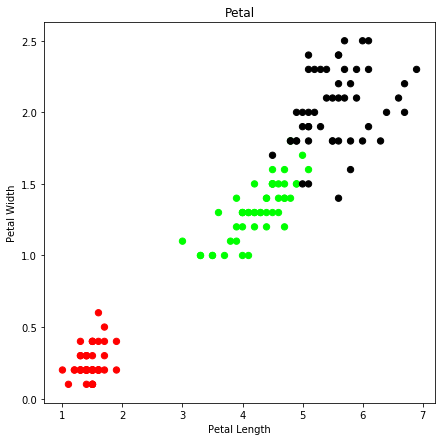

In [31]:
# Set the size of the plot
plt.figure(figsize=(7,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black'])
 
# Plotting the petals
 
plt.scatter(x.Petal_Length, x.Petal_Width, c=colormap[y.Targets], s=40)
plt.title('Petal')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')

### K-Means model

Setting up the K-Means model is pretty simple with scikit-learn. The simplest approach really just needs one variable, namely the number of clusters.

For an initial display, we create the model and specify the number of clusters the model should find (n_clusters=3) next we fit the model to the data.

In [32]:
# K Means Cluster
model = KMeans(n_clusters=3)
model.fit(x)

# This is what KMeans thought
model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

## Well... that sure tells us a lot... not. Let us try visualising once more!

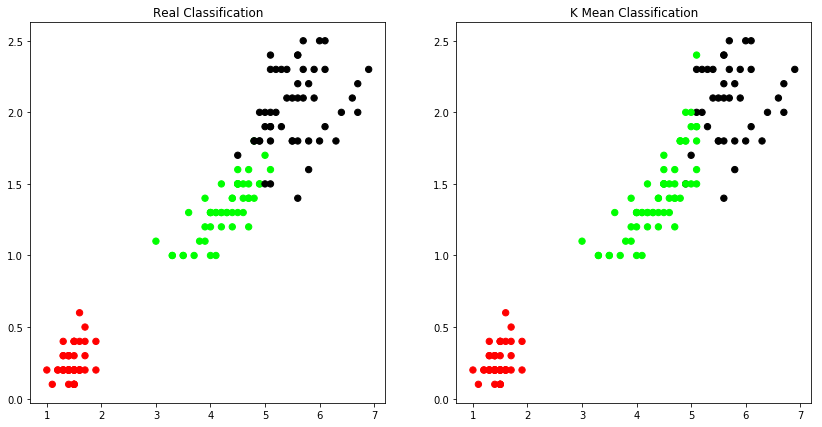

In [33]:
# View the results
# Set the size of the plot
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black'])
 
# Plot the Original Classifications
plt.subplot(1, 2, 1)
plt.scatter(x.Petal_Length, x.Petal_Width, c=colormap[y.Targets], s=40)
plt.title('Real Classification')
 
# Plot the Models Classifications
plt.subplot(1, 2, 2)
plt.scatter(x.Petal_Length, x.Petal_Width, c=colormap[model.labels_], s=40)
plt.title('K Mean Classification')
predY = model.labels_

The order of colors might be messed up. The perfectionists that we are, we can not let this slide! Now because the approach is unsupervised, the nubmer assignment can be different every time. Hence the code below might have to be different for you to correct the colors.

In [34]:
# The fix, we convert all the 0s to 2s and 1s to 0s and 2s to 1s.
predY = np.choose(model.labels_, [2, 0, 1]).astype(np.int64)
print(list(y.Targets))
print (model.labels_)
print (predY)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 0

Text(0.5,1,'K Mean Classification')

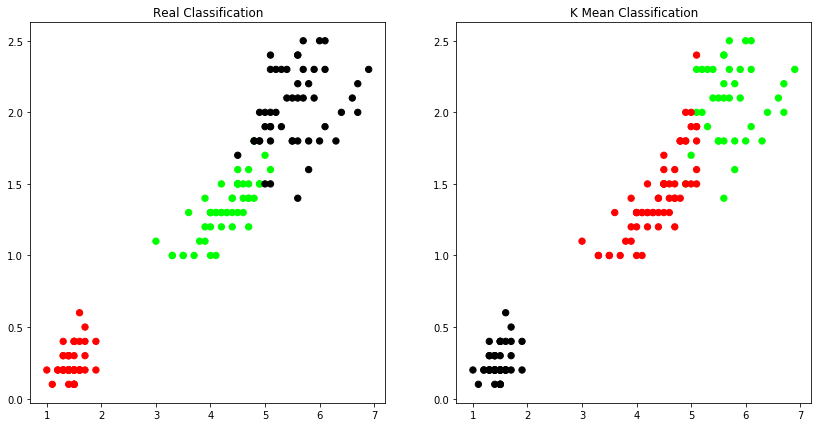

In [35]:
# View the results
# Set the size of the plot
plt.figure(figsize=(14,7))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black'])

# Plot Orginal
plt.subplot(1, 2, 1)
plt.scatter(x.Petal_Length, x.Petal_Width, c=colormap[y.Targets], s=40)
plt.title('Real Classification')
 
# Plot Predicted with corrected values
plt.subplot(1, 2, 2)
plt.scatter(x.Petal_Length, x.Petal_Width, c=colormap[predY], s=40)
plt.title('K Mean Classification')

No we can see that the K Means classifier has identified one class correctly (red) but some blacks have been classed as greens and vice versa.

### Measuring Performance
There are a number of ways in which we can measure a classifiers performance. Here we will calculate the accuracy and also the confusion matrix.

We need to values y which is the true (original) values and predY which are the models values.

In [36]:
# Performance Metrics (All hail the built-ins!)
sm.accuracy_score(y, predY)

0.013333333333333334

My result was 0.89, so we can say that the model has an accuracy of 89%. Seeing how the we worked with an unsupervised model, these certainly don't look like bad results! Although accuracy can be used in multi-class classification/clustering. We also often use the mean Average Precision instead (mAP, do note that `Average Precision` is a metric by itself, hence we can take the mean of it). This metrics works better with skewed data (e.g. with accuracy you can have the problem that your data consist of 90% of class 1s, your model just always predicts 1. Easy 90% accuracy. But your model is probably worthless).

Another thing you can look at is the confusion matrix. This matrix can tell you which class has been misclassified as another class in detail.
You can see which classes get mixed up, and hence might be messing up your results.

In [37]:
# Confusion Matrix
sm.confusion_matrix(y, predY)

array([[ 0,  0, 50],
       [48,  2,  0],
       [14, 36,  0]], dtype=int64)

We can derive the following things from this matrix:
    
* All objects that are of class 0, have also been classified as 0.
* 48  objects that are of class 1, have been classified as 1. 2 of those objects have been classified as class 2.
* 36 objects of class 2 were classified correctly. 14 objects of class 2 were classified as class 1.


### Are we note forgetting something?
So in the example above we just picked the number of clusters to be equal to 3. We came to this number by simply abusing the fact that we know the dataset. But sadly we are not all-knowing, and we might encounter datasets where we do not know the number of unique classes. Which begs the question, is there a way to determina this number if you do not know the dataset? (Hint: yes)

In [38]:
# Let's grab our example again:
iris = datasets.load_iris()
# Store the inputs as a Pandas Dataframe and set the column names
x = pd.DataFrame(iris.data)
x.columns = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width']
 
y = pd.DataFrame(iris.target)
y.columns = ['Targets']

[Paraphrased from here](https://www.datascience.com/blog/k-means-clustering)

To find the number of clusters in the data, we can run the K-means clustering algorithm for a range of K values and compare the results. In general, there is no method for determining exact value of K, but an accurate estimate can be obtained using the following simple technique.

One of the metrics that is commonly used to compare results across different values of K is the mean distance between data points and their cluster centroid. Since increasing the number of clusters will always reduce the distance to data points, increasing K will always decrease this metric, to the extreme of reaching zero when K is the same as the number of data points. Thus, this metric cannot be used as the sole target. Instead, mean distance to the centroid as a function of K is plotted and the `elbow point`, where the rate of decrease sharply shifts, can be used to roughly determine K.

In [39]:
# K Means Cluster
model = KMeans(n_clusters=3)
model.fit(x)

print(model)
print()

# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

# This is what KMeans thought
model.inertia_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)



78.94084142614602

In [40]:
inertias = []

for i in range(1, 10):
    model = KMeans(n_clusters=i)
    model.fit(x)
    inertias.append(model.inertia_)
print(inertias)

[680.8244, 152.36870647733906, 78.94084142614602, 57.345409315718165, 46.53558205128205, 39.27787900008488, 34.18920546865627, 29.88769644828856, 28.02262885154062]


In [41]:
f = figure(plot_width=400, plot_height=250)

# Create the line
x = boston_df["RM"]
f.line(range(1, 10), inertias)

## Add some axis information
f.xaxis.axis_label = 'Number of Clusters'
f.yaxis.axis_label = 'Inertia'

show(f)

So well, hopefully you see why we refer to a an `elbow point`. We look for a change in direction between inertia values.
Here we see a distinct change at both 2 and 3 clusters. Normally you wouldh ave tried both, to see which fits best. But remember.. if you have knowledge of a dataset, you can choose to cheat. Just document to your reader why you chose a specific value. We do not like `Magic numbers` (values that appear out of thin air).